In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
np.set_printoptions(precision=3)
# better display of review text in dataframes
pd.set_option('display.max_colwidth', None) 

# Seaborn options
sns.set(style="whitegrid", font_scale=1.4)

# Auto reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import tensorflow as tf
assert tf.__version__ >= "2.0"

In [49]:
import re
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Prepare data

## Load dataset

In [50]:
import pandas as pd
file_name='C:/Users/21264/Desktop/S8/STAGE LIP6/Datasets/French constitution.csv'
data_df = pd.read_csv('C:/Users/21264/Desktop/S8/STAGE LIP6/Datasets/French constitution.csv')
data_df = data_df.drop(['title','articles__see_more','introduction','articles__section','articles__created_by__001','articles__created_by__002','articles__modified_by__001','articles__modified_by__002','articles__index'], axis=1)
data_df=data_df.dropna(how = 'any')


## Preprocess dataset

In [51]:
import string
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words_en = stopwords.words()
stop_words_fr = stopwords.words('french')
stop_words = stop_words_en + stop_words_fr 

def process_text(value):
    
    try:
         # Remove digits
        value = re.sub(r'\d','',value)
        # Remove punctuation, unnecessary whitespaces, and convert to lower case
        value = value.encode('utf-8', 'ignore').decode('utf-8')
        value = re.sub(r'\s+', ' ', value.strip()
                                .lower()
                                .translate(str.maketrans(string.punctuation,
                                                         ' ' * len(string.punctuation))))

        # Remove stop words and unnecessary words
        words = value.split(' ')
        value = ' '.join(w for w in words if (not w in stop_words) and (len(w) > 2))
        
    except Exception as e:
        print(f"Error: {e}")
    
    return value    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\21264\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:

data_df['processedtext'] = data_df['articles__text'].apply(lambda x: process_text(x))
data_df.describe()




,articles__text,articles__title,processedtext
count,105,105,105
unique,105,105,105
top,"Le Parlement vote les projets de loi de finances dans les conditions prévues par une loi organique. Si l'Assemblée nationale ne s'est pas prononcée en première lecture dans le délai de quarante jours après le dépôt d'un projet, le Gouvernement saisit le Sénat qui doit statuer dans un délai de quinze jours. Il est ensuite procédé dans les conditions prévues à l'article 45. Si le Parlement ne s'est pas prononcé dans un délai de soixante-dix jours, les dispositions du projet peuvent être mises en vigueur par ordonnance. Si la loi de finances fixant les ressources et les charges d'un exercice n'a pas été déposée en temps utile pour être promulguée avant le début de cet exercice, le Gouvernement demande d'urgence au Parlement l'autorisation de percevoir les impôts et ouvre par décret les crédits se rapportant aux services votés. Les délais prévus au présent article sont suspendus lorsque le Parlement n'est pas en session.",Article 34-1,matières autres celles domaine loi caractère réglementaire textes forme législative intervenus matières peuvent être modifiés décrets pris après avis conseil etat ceux textes interviendraient après entrée vigueur présente constitution pourront être modifiés décret conseil constitutionnel déclaré caractère réglementaire vertu alinéa précédent
freq,1,1,1


In [53]:
corpus_docs = []
corpus_labels = []
n = len(data_df)
corpus_docs = corpus_docs + data_df.iloc[:,0].tolist()
for i in range (1,n+1):
    corpus_labels = corpus_labels + [i]


In [54]:
n,len(corpus_docs)

(105, 105)

In [55]:
corpus_labels[0:2],corpus_docs[0:2]

([1, 2],
 ["Le Peuple français proclame solennellement son attachement aux Droits de l'Homme et aux principes de la souveraineté nationale tels qu'ils sont définis par la Déclaration de 1789, confirmée et complétée par le préambule de la Constitution de 1946, ainsi qu'aux droits et devoirs définis dans la Charte de l'environnement de 2004. En vertu de ces principes et de celui de la libre détermination des peuples, la République offre aux territoires d'outre-mer qui manifestent la volonté d'y adhérer des institutions nouvelles fondées sur l'idéal commun de liberté, d'égalité et de fraternité et conçues en vue de leur évolution démocratique.",
  "La France est une République indivisible, laïque, démocratique et sociale. Elle assure l'égalité devant la loi de tous les citoyens sans distinction d'origine, de race ou de religion. Elle respecte toutes les croyances. Son organisation est décentralisée.La loi favorise l'égal accès des femmes et des hommes aux mandats électoraux et fonctions é

In [56]:
corpus_df = pd.DataFrame({'article':corpus_docs,'no_article':corpus_labels})
corpus_df.head()

,article,no_article
0,"Le Peuple français proclame solennellement son attachement aux Droits de l'Homme et aux principes de la souveraineté nationale tels qu'ils sont définis par la Déclaration de 1789, confirmée et complétée par le préambule de la Constitution de 1946, ainsi qu'aux droits et devoirs définis dans la Charte de l'environnement de 2004. En vertu de ces principes et de celui de la libre détermination des peuples, la République offre aux territoires d'outre-mer qui manifestent la volonté d'y adhérer des institutions nouvelles fondées sur l'idéal commun de liberté, d'égalité et de fraternité et conçues en vue de leur évolution démocratique.",1
1,"La France est une République indivisible, laïque, démocratique et sociale. Elle assure l'égalité devant la loi de tous les citoyens sans distinction d'origine, de race ou de religion. Elle respecte toutes les croyances. Son organisation est décentralisée.La loi favorise l'égal accès des femmes et des hommes aux mandats électoraux et fonctions électives, ainsi qu'aux responsabilités professionnelles et sociales.",2
2,"La langue de la République est le français. L'emblème national est le drapeau tricolore, bleu, blanc, rouge. L'hymne national est la ""Marseillaise"". La devise de la République est ""Liberté, Egalité, Fraternité"". Son principe est : gouvernement du peuple, par le peuple et pour le peuple.",3
3,"La souveraineté nationale appartient au peuple qui l'exerce par ses représentants et par la voie du référendum. Aucune section du peuple ni aucun individu ne peut s'en attribuer l'exercice. Le suffrage peut être direct ou indirect dans les conditions prévues par la Constitution. Il est toujours universel, égal et secret. Sont électeurs, dans les conditions déterminées par la loi, tous les nationaux français majeurs des deux sexes, jouissant de leurs droits civils et politiques.",4
4,Les partis et groupements politiques concourent à l'expression du suffrage. Ils se forment et exercent leur activité librement. Ils doivent respecter les principes de la souveraineté nationale et de la démocratie.Ils contribuent à la mise en oeuvre du principe énoncé au second alinéa de l'article 1er dans les conditions déterminées par la loi.La loi garantit les expressions pluralistes des opinions et la participation équitable des partis et groupements politiques à la vie démocratique de la Nation.,5


 ## Analyse  de la distribution des caracteres :


In [57]:
# temporary variable
corpus_ = corpus_df.article
corpus_

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Le Peuple français proclame solennellement son attachement aux Droits de l'Homme et aux principes de la souveraineté nationale tels qu'ils sont définis par la Déclaration de 1789, confirmée et complétée par le préambule de la Constitution de 1946, ainsi qu'aux droits et devoirs définis dans la Charte de l'environnement de 2004. En vertu de ces principes et de celui de la libre détermination des peuples, la République offre aux territoire

In [58]:
corpus_chars_list = "\n".join(corpus_)
print(type(corpus_chars_list),len(corpus_chars_list))
corpus_chars_list

<class 'str'> 73015


'Le Peuple français proclame solennellement son attachement aux Droits de l\'Homme et aux principes de la souveraineté nationale tels qu\'ils sont définis par la Déclaration de 1789, confirmée et complétée par le préambule de la Constitution de 1946, ainsi qu\'aux droits et devoirs définis dans la Charte de l\'environnement de 2004. En vertu de ces principes et de celui de la libre détermination des peuples, la République offre aux territoires d\'outre-mer qui manifestent la volonté d\'y adhérer des institutions nouvelles fondées sur l\'idéal commun de liberté, d\'égalité et de fraternité et conçues en vue de leur évolution démocratique.\nLa France est une République indivisible, laïque, démocratique et sociale. Elle assure l\'égalité devant la loi de tous les citoyens sans distinction d\'origine, de race ou de religion. Elle respecte toutes les croyances. Son organisation est décentralisée.La loi favorise l\'égal accès des femmes et des hommes aux mandats électoraux et fonctions élect

In [59]:
fdist = FreqDist([c for c in corpus_chars_list])

In [60]:
print("number of characters:" + str(fdist.N()))
print("number of unique characters:" + str(fdist.B()))

number of characters:73015
number of unique characters:80


In [61]:
u = list(fdist.keys())
u.sort()
print('List of unique characters in the corpus:')
print(u)

List of unique characters in the corpus:
['\n', ' ', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', '°', 'À', 'É', 'à', 'â', 'ç', 'è', 'é', 'ê', 'î', 'ï', 'ô', 'ù', '’']


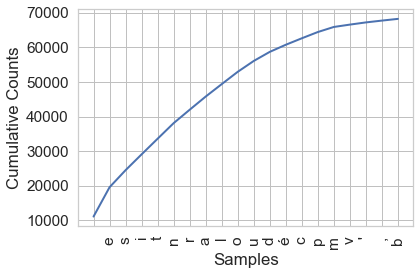

In [62]:
fdist.plot(20, cumulative=True) 
# Les TOP 20 CHARACTERES en mode cumulative (similarity avec loi de pareto )


In [63]:
# the 10 most frequent characters in the corpus
#pd.DataFrame(fdist1.most_common(20))
fdist.most_common(5)

[(' ', 11139), ('e', 8459), ('s', 4921), ('i', 4561), ('t', 4513)]

Observations et conclusions

Type de caractères : lettres françaises, chiffres, ponctuation et espace.
Aucun idée sur la présence d'un caratère spécial qui nécessite une normalisation/un prétraitement particulier.

## Prétraitement et nettoyage du texte

Pipeline :
1. Identification de la langue
2. Segmentation des phrases
3. Supprimer les caractères non textuels
4. Convertir en minuscules
5. Tokenisation
6. Stemming (heuristique simple pour la normalisation des mots)
7. Correction orthographique

### Identification de la langue

### Segmentation des phrases
Divisez les documents en phrases.

In [64]:
for c in ['.','!','?']:
    print(c,fdist[c])

. 448
! 0
? 0


In [65]:
from nltk.tokenize import sent_tokenize
L1 = [len(article) for article in corpus_df.article]
L2 = [len(sent_tokenize(article)) for article in corpus_df.article]
article_len_df_ = pd.DataFrame({'n_chars' : L1, 'n_sents' : L2, \
                            'n_chars_per_sent' : np.array(L1)/np.array(L2)})
article_len_df_

,n_chars,n_sents,n_chars_per_sent
0,636,2,318.000000
1,414,4,103.500000
2,287,5,57.400000
3,482,5,96.400000
4,504,3,168.000000
...,...,...,...
100,964,5,192.800000
101,1146,4,286.500000
102,1188,9,132.000000
103,803,3,267.666667


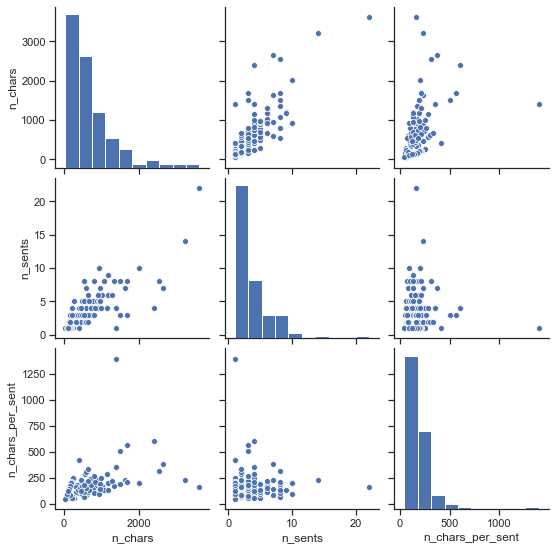

In [66]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(article_len_df_)

#### Créer un corpus de phrases

In [67]:
corpus_sentences_ = [sent_tokenize(doc) for doc in corpus_df.article]
len(corpus_sentences_),corpus_sentences_[0]

(105,
 ["Le Peuple français proclame solennellement son attachement aux Droits de l'Homme et aux principes de la souveraineté nationale tels qu'ils sont définis par la Déclaration de 1789, confirmée et complétée par le préambule de la Constitution de 1946, ainsi qu'aux droits et devoirs définis dans la Charte de l'environnement de 2004.",
  "En vertu de ces principes et de celui de la libre détermination des peuples, la République offre aux territoires d'outre-mer qui manifestent la volonté d'y adhérer des institutions nouvelles fondées sur l'idéal commun de liberté, d'égalité et de fraternité et conçues en vue de leur évolution démocratique."])

In [68]:
u = [(sent,corpus_df.no_article[i]) for i,doc in enumerate(corpus_sentences_) for sent in doc]
corpus_sent_df = pd.DataFrame(u)
corpus_sent_df.columns = ['sentence','qlabel']
assert(len(corpus_df)<=len(corpus_sent_df))
len(corpus_df),len(corpus_sent_df)

(105, 410)

In [69]:
corpus_sent_df.head()

,sentence,qlabel
0,"Le Peuple français proclame solennellement son attachement aux Droits de l'Homme et aux principes de la souveraineté nationale tels qu'ils sont définis par la Déclaration de 1789, confirmée et complétée par le préambule de la Constitution de 1946, ainsi qu'aux droits et devoirs définis dans la Charte de l'environnement de 2004.",1
1,"En vertu de ces principes et de celui de la libre détermination des peuples, la République offre aux territoires d'outre-mer qui manifestent la volonté d'y adhérer des institutions nouvelles fondées sur l'idéal commun de liberté, d'égalité et de fraternité et conçues en vue de leur évolution démocratique.",1
2,"La France est une République indivisible, laïque, démocratique et sociale.",2
3,"Elle assure l'égalité devant la loi de tous les citoyens sans distinction d'origine, de race ou de religion.",2
4,Elle respecte toutes les croyances.,2


### Tokenisation
- convertir en minuscules.
- convertir le corpus en liste de mots
- supprimer tous les caractères autres que les lettres (dans notre cas, la ponctuation)

In [70]:
from transformers import CamembertTokenizer, CamembertModel
model_name = "camembert-base"
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = CamembertModel.from_pretrained('camembert-base')

In [71]:
# convert les phrases en miniscule et tokenisation avec Camemebert tokenizer
corpus_tokens_ = [tokenizer.tokenize(doc.lower()) for doc in corpus_sent_df.sentence]
assert(len(corpus_tokens_)==len(corpus_sent_df))
corpus_tokens_[0] #la première phrase tokenized

['▁le',
 '▁peuple',
 '▁français',
 '▁proclame',
 '▁solennelle',
 'ment',
 '▁son',
 '▁attachement',
 '▁aux',
 '▁droits',
 '▁de',
 '▁l',
 "'",
 'homme',
 '▁et',
 '▁aux',
 '▁principes',
 '▁de',
 '▁la',
 '▁souveraineté',
 '▁nationale',
 '▁tels',
 '▁qu',
 "'",
 'ils',
 '▁sont',
 '▁définis',
 '▁par',
 '▁la',
 '▁déclaration',
 '▁de',
 '▁1789',
 ',',
 '▁confirmée',
 '▁et',
 '▁complétée',
 '▁par',
 '▁le',
 '▁préambule',
 '▁de',
 '▁la',
 '▁constitution',
 '▁de',
 '▁1946',
 ',',
 '▁ainsi',
 '▁qu',
 "'",
 'aux',
 '▁droits',
 '▁et',
 '▁devoirs',
 '▁définis',
 '▁dans',
 '▁la',
 '▁charte',
 '▁de',
 '▁l',
 "'",
 'environnement',
 '▁de',
 '▁2004',
 '.']

In [72]:
corpus_sent_df['tokenized_sent'] = corpus_tokens_
corpus_sent_df.head()


,sentence,qlabel,tokenized_sent
0,"Le Peuple français proclame solennellement son attachement aux Droits de l'Homme et aux principes de la souveraineté nationale tels qu'ils sont définis par la Déclaration de 1789, confirmée et complétée par le préambule de la Constitution de 1946, ainsi qu'aux droits et devoirs définis dans la Charte de l'environnement de 2004.",1,"[▁le, ▁peuple, ▁français, ▁proclame, ▁solennelle, ment, ▁son, ▁attachement, ▁aux, ▁droits, ▁de, ▁l, ', homme, ▁et, ▁aux, ▁principes, ▁de, ▁la, ▁souveraineté, ▁nationale, ▁tels, ▁qu, ', ils, ▁sont, ▁définis, ▁par, ▁la, ▁déclaration, ▁de, ▁1789, ,, ▁confirmée, ▁et, ▁complétée, ▁par, ▁le, ▁préambule, ▁de, ▁la, ▁constitution, ▁de, ▁1946, ,, ▁ainsi, ▁qu, ', aux, ▁droits, ▁et, ▁devoirs, ▁définis, ▁dans, ▁la, ▁charte, ▁de, ▁l, ', environnement, ▁de, ▁2004, .]"
1,"En vertu de ces principes et de celui de la libre détermination des peuples, la République offre aux territoires d'outre-mer qui manifestent la volonté d'y adhérer des institutions nouvelles fondées sur l'idéal commun de liberté, d'égalité et de fraternité et conçues en vue de leur évolution démocratique.",1,"[▁en, ▁vertu, ▁de, ▁ces, ▁principes, ▁et, ▁de, ▁celui, ▁de, ▁la, ▁libre, ▁détermination, ▁des, ▁peuples, ,, ▁la, ▁république, ▁offre, ▁aux, ▁territoires, ▁d, ', outre, -, mer, ▁qui, ▁manifestent, ▁la, ▁volonté, ▁d, ', y, ▁adhérer, ▁des, ▁institutions, ▁nouvelles, ▁fondée, s, ▁sur, ▁l, ', idéal, ▁commun, ▁de, ▁liberté, ,, ▁d, ', égalité, ▁et, ▁de, ▁fraternité, ▁et, ▁conçues, ▁en, ▁vue, ▁de, ▁leur, ▁évolution, ▁démocratique, .]"
2,"La France est une République indivisible, laïque, démocratique et sociale.",2,"[▁la, ▁france, ▁est, ▁une, ▁république, ▁indi, visible, ,, ▁laïque, ,, ▁démocratique, ▁et, ▁sociale, .]"
3,"Elle assure l'égalité devant la loi de tous les citoyens sans distinction d'origine, de race ou de religion.",2,"[▁elle, ▁assure, ▁l, ', égalité, ▁devant, ▁la, ▁loi, ▁de, ▁tous, ▁les, ▁citoyens, ▁sans, ▁distinction, ▁d, ', origine, ,, ▁de, ▁race, ▁ou, ▁de, ▁religion, .]"
4,Elle respecte toutes les croyances.,2,"[▁elle, ▁respecte, ▁toutes, ▁les, ▁croyances, .]"


In [73]:
## Word frequency distribution
corpus_words_ = [word for sent in corpus_sent_df.tokenized_sent for word in sent]
fdist2 = FreqDist(corpus_words_)
fdist2.N(),fdist2.B()

(14315, 1741)

In [74]:
fdist2.most_common(10)

[('▁de', 717),
 ("'", 634),
 (',', 516),
 ('▁la', 465),
 ('.', 430),
 ('▁le', 386),
 ('▁l', 361),
 ('▁les', 335),
 ('▁des', 262),
 ('▁et', 248)]

Average length: 36.9
Max length: 265


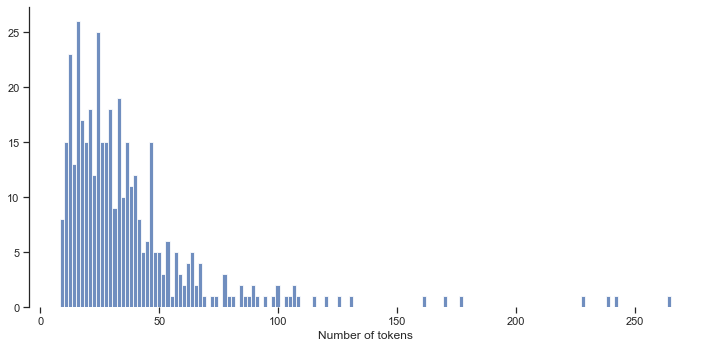

In [75]:
articles_len = [len(tokenizer.encode(article, max_length=512))
                          for article in corpus_sent_df.tokenized_sent]
print("Average length: {:.1f}".format(np.mean(articles_len)))
print("Max length: {}".format(max(articles_len)))

plt.figure(figsize=(10,5))
ax = sns.distplot(articles_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Number of tokens')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

# Saving plot
fig = ax.get_figure()


### Supprimer les stopwords avec NLTK
Nous utiliserons la liste par défaut des mots-clés de NLTK pour la langue française.

#### Charger une liste standard de mots vides

In [76]:
# Load NLTK stop words
stop_words_fr = stopwords.words('french')
stop_words_fr = set(stop_words_fr)
len(stop_words_fr)

157